# Temperature Profile

In [1]:
#imports libs and data
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pickle, json

import Classes.LPPic_fields as fl
import Classes.LPPic as LP
import Classes.LPPic_newwalls as nw
from functions import (simpleplot, ne_Bolz, Te_eff_calcl, phi_drop,
                        sigma_maxw_unsat,
                        sigma_maxw_sat,
                        newSigma_maxw,)

import matplotlib as mpl
import matplotlib.pyplot as plt

qe_v = 1.6021766E-19
me_v =  9.109E-31 
mi_v = 219.6E-27
eps0_v = 8.854187817e-12

savepath = "../images/"

sigma_0 = 0.5
sigma_max= 2.9

Paper_style = json.load(open("Paperstyle.json",'r'))
mpl.style.use(Paper_style)

In [2]:
#folders = ["131_eps50",
#          "132_eps45",
#          #"133_eps25",
#          "134_eps10",
#          "135_eps200",
#          "136_LongX",
#          ]
folders = ["143_eps200"]
#root = "/run/media/tavant/Data3/"
root = "/home/tavant/Data/R-theta/"

paths = [root + fol +"/" for fol in folders]

In [3]:
def returnTemean(run, start = 0.5):
    
    tmax = run._nT
    tmin = int(start*tmax)
    Nt = tmax - tmin + 1
    Temean = np.zeros((run._xmax+1,run._ymax+1))

    for t in np.arange(tmin,tmax):
        print(f"\r {t} over {tmax} time step",end = "")
        Temean += run.return_fromkey(t,'Eke(1)') + run.return_fromkey(t,'Eke(2)') + run.return_fromkey(t,'Eke(3)')
    
    Temean *= 2/3
    
    return Temean / Nt

def returnVmean(run, start = 0.5):
    
    tmax = run._nT
    tmin = int(start*tmax)
    Nt = tmax - tmin + 1
    nmean = np.zeros((run._xmax+1,run._ymax+1))
    J1mean = np.zeros((run._xmax+1,run._ymax+1))
    J2mean = np.zeros((run._xmax+1,run._ymax+1))
    J3mean = np.zeros((run._xmax+1,run._ymax+1))
    
    for t in np.arange(tmin,tmax):
        print(f"\r {t} over {tmax} time step",end = "")
        
        ntemp = run.return_fromkey(t,'Nume') 
        nmean += ntemp
        J1mean += run.return_fromkey(t,'Je(1)') / ntemp
        J2mean += run.return_fromkey(t,'Je(2)') / ntemp
        J3mean += run.return_fromkey(t,'Je(3)') / ntemp
        
    
    return nmean/Nt, -J1mean/qe_v/Nt, -J2mean/qe_v/Nt, -J3mean/qe_v/Nt

## Load the data

In [4]:
#Load the Data
filename = 'tabgrid_data.dat'

if True:
    data = pickle.load(open(filename,"rb"))
else:

    data = pickle.load(open(filename,"rb"))
    for p in paths:
        run = fl.field(p)
        n = p.split("/")[-2]
        print(n)
        print("get Te")
        Temean = np.zeros((run._xmax+1,run._ymax+1))
        try:
            Temean = returnTemean(run, 0.7)
        except KeyError:
            Temean = np.zeros((run._xmax+1,run._ymax+1))

        print("Get ve and ne")
        nmean, J1mean, J2mean, J3mean = returnVmean(run, 0.7)

        data[n] = {"Te":Temean,
                    "n":nmean,
                    "v1":J1mean,
                    "v2":J2mean,
                    "v3":J3mean,
                  }
    pickle.dump(data,open(filename,"wb"))


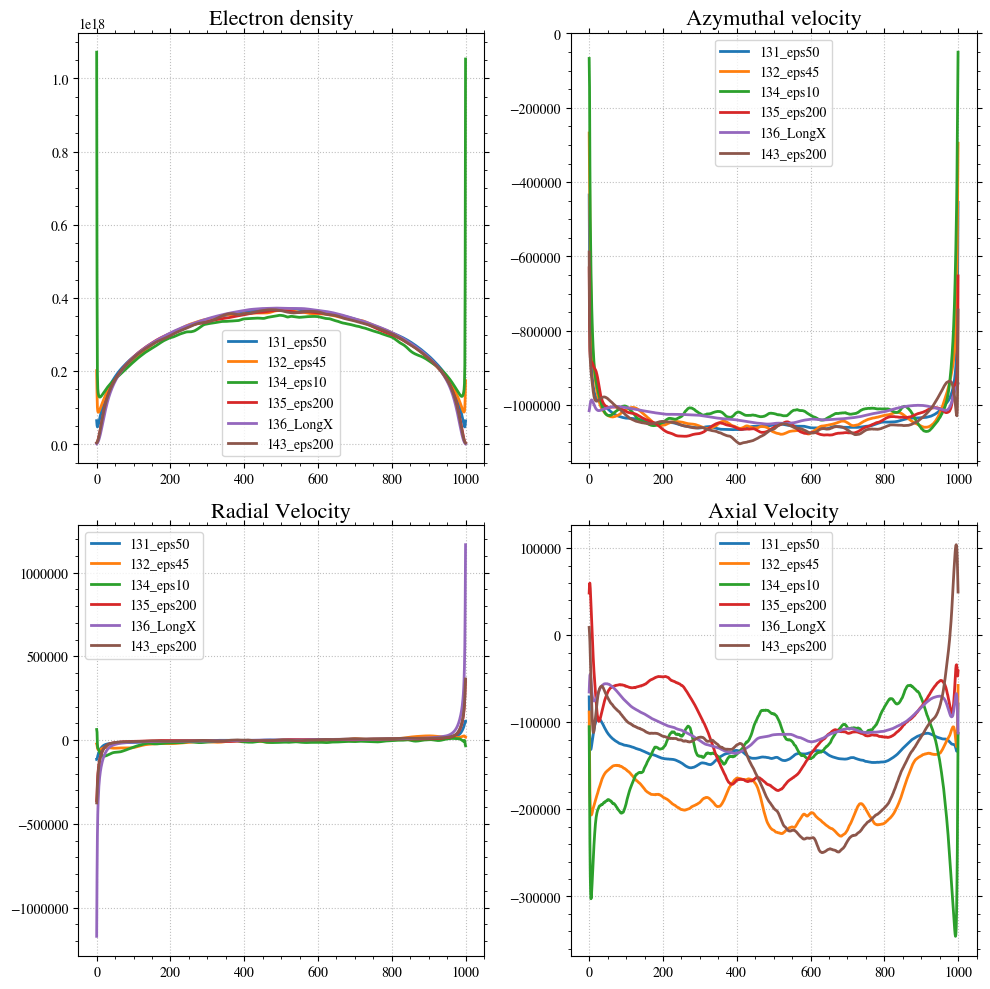

In [12]:
#plot
fig, axarr = plt.subplots(2,2,figsize = (10,10))

axarr = axarr.flatten()

for k,v in data.items():
    #print(k)
    for ax, st in zip(axarr, ["n","v1","v2","v3"]):
        tab = (v[st].mean(axis = 0))
        ax.plot(tab, label = k)
        
for ax in axarr.flatten():
    ax.legend()
    #ax.set_yscale('log')
    ax.grid(True,"grey")


axarr[0].set_title("Electron density")
axarr[1].set_title("Azymuthal velocity")
axarr[2].set_title("Radial Velocity")
axarr[3].set_title("Axial Velocity")

fig.savefig("ne_ve_profiles.png")


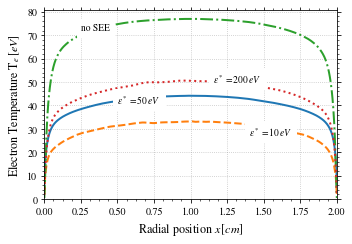

In [6]:


fig2, ax5 = plt.subplots(1,1,figsize = (5,3.5))

Rtab = np.linspace(0,2,1001)
styles = ["-","--","-.",":"]
compter = 0
for k,v in data.items():
    tab =  v["Te"].mean(axis = 0)
    tab *= 0.9
    if tab.mean() > 0:
        ax5.plot(Rtab,tab, label = k, linestyle = styles[compter%4])
        compter += 1

ax5.set_xlim(0,2)
ax5.set_ylim(ymin=0)

text_size = 9.5
kwargs = {"size":text_size, "backgroundcolor":"w" }

ax5.text(0.25,80*0.9,'no SEE', **kwargs)
ax5.text(1.15,55*0.9,r'$\epsilon^* = 200 \/eV$', **kwargs)
ax5.text(0.5,45*0.9,r'$\epsilon^* = 50\/ eV$',**kwargs)
ax5.text(1.4,30*0.9,r'$\epsilon^* = 10 \/eV$', **kwargs)

#ax5.legend()
ax5.grid(True,"grey")
ax5.set_xlabel(r"Radial position $x \/[cm]$")
ax5.set_ylabel(r"Electron Temperature T$_e \/[eV]$")

fig2.savefig("/home/tavant/these/Te_profiles.pdf")


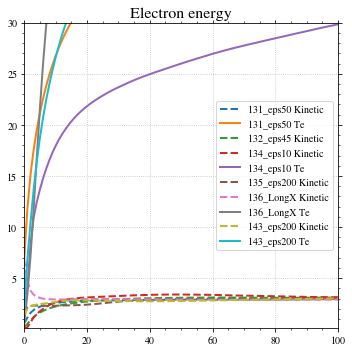

In [43]:
#plot
fig, ax = plt.subplots(1,figsize = (5,5))

for k,v in data.items():
    tab = (v["v1"]**2 + v["v2"]**2 + v["v3"]**2).mean(axis = 0)
    tab *= me_v/(2*qe_v)
    ax.plot(tab,"--", label = k+" Kinetic")
    
    tab = v["Te"].mean(axis = 0)
    if tab.mean() > 0:
        ax.plot(tab, label = k+" Te")
        

ax.legend()

ax.set_title("Electron energy")
#ax.set_yscale("log")
ax.set_ylim(0.1,30)
ax.set_xlim(0,100);

(0, 1000)

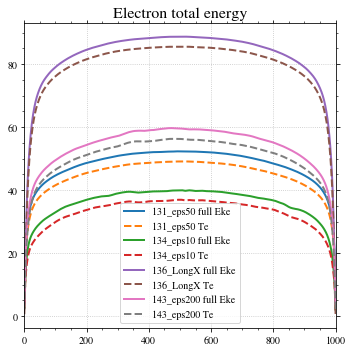

In [12]:
# plot Te
fig, ax = plt.subplots(1,figsize = (5,5))

for k,v in data.items():
    tab = (v["v1"]**2 + v["v2"]**2 + v["v3"]**2).mean(axis = 0)
    tab *= me_v/(2*qe_v)
    tab += v["Te"].mean(axis = 0)
    if v["Te"].mean() >0:
        ax.plot(tab, label = k+" full Eke")
        
    tab =  v["Te"].mean(axis = 0)
    if tab.mean() > 0:
        ax.plot(tab,'--', label = k+" Te")
        

ax.legend()

ax.set_title("Electron total energy")
#ax.set_yscale("log")
#ax.set_ylim(0.1,30)
ax.set_xlim(0,1000)

found 169 files
[11.21362797  0.          4.93713922  0.          3.67603179  6.40504603]


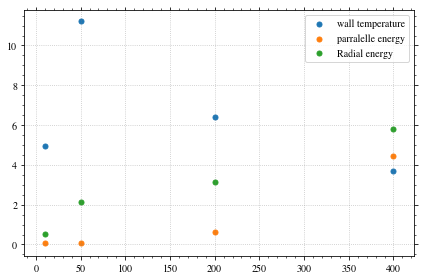

In [41]:
Ncels = 3

eps_v = np.array([fl.field(p).inputobject.parameters["epsilon_star"] for p in paths])
eps_v = np.array([50,45,10,200,400,200])
Te_w = np.array([v["Te"][:,0:Ncels].mean() for k,v in data.items()])
print(Te_w)
Eke_wpe = np.array([ (v["v2"][:,0:Ncels]**2).mean()*me_v/qe_v for k,v in data.items()])
Eke_wpa = np.array([(v["v3"][:,0:Ncels]**2 + v["v1"][:,0:Ncels]**2).mean()*me_v/qe_v for k,v in data.items()])

Ve_x = np.array([(v["v1"][:,0:Ncels].mean()) for k,v in data.items()])
Ve_y = np.array([v["v2"][:,0:Ncels].mean() for k,v in data.items()])
Ve_z = np.array([v["v3"][:,0:Ncels].mean() for k,v in data.items()])

mask = (Te_w > 0)
Ve_x, Ve_y, Ve_z = (Ve_x[mask], Ve_y[mask], Ve_z[mask])
eps_v, Te_w, Eke_wpe, Eke_wpa =  (eps_v[mask], Te_w[mask] , Eke_wpe[mask], Eke_wpa[mask])


plt.scatter(eps_v, Te_w , label = "wall temperature")
plt.scatter(eps_v, Eke_wpe , label = "parralelle energy")
plt.scatter(eps_v, Eke_wpa , label = "Radial energy")
#plt.scatter(eps_v, Te_eff_calcl())

plt.legend()

# Symbolic integration
For a 3D Maxwellian

In [33]:
# Formal calculus
import sympy as sym 
from sympy import oo, pi

sym.init_printing() 
Te2  = sym.Symbol('2T_e' , positive=True, nonzero = True)
Te  = sym.Symbol('T_e' , positive=True, nonzero = True)

me  = sym.Symbol('m_e',  positive=True)
ne  = sym.Symbol('n_e',  positive=True)

from sympy.physics.vector import ReferenceFrame

N = ReferenceFrame('N')
vx = sym.Symbol("v_x")
vy = sym.Symbol("v_y")
vz = sym.Symbol("v_z")

v3 = vx*N.x + vy*N.y + vz*N.z
vdx = sym.Symbol("v_{dx}", positive = True)
vdy = sym.Symbol("v_{dy}", positive = True)
vdz = sym.Symbol("v_{dz}", positive = True)
vd3 = vdx*N.x + vdy*N.y + vdz*N.z

Maxw3 = ne* sym.sqrt(me/(Te*2*pi))**3 * sym.exp( - (v3-vd3).magnitude()**2* me/(Te*2))

def integ(expr, var , binf = - oo, bsup = oo ):
    """Integrate any expression with respect to a variable var between 2 borns"""
    
    return sym.integrate(expr, (var,binf,bsup))

def integ3(exp,binfy = -oo ,bsupy = oo):
    
    i1 = integ(exp, var = vx, binf = -oo, bsup = oo ).simplify()
    i2 = integ(i1, var = vz, binf = -oo, bsup = oo ).simplify()
    i3 = integ(i2, var = vy, binf = binfy, bsup = bsupy )
    return i3

sigma_0, epstar = sym.Rational(1,2), sym.Symbol("\epsilon^*")

def sig_lin(e):
    s = sigma_0 + (1 - sigma_0)*e/epstar
    return s


In [34]:
# Thermal flux
Gamma_e = integ3(vy*Maxw3, 0, oo)

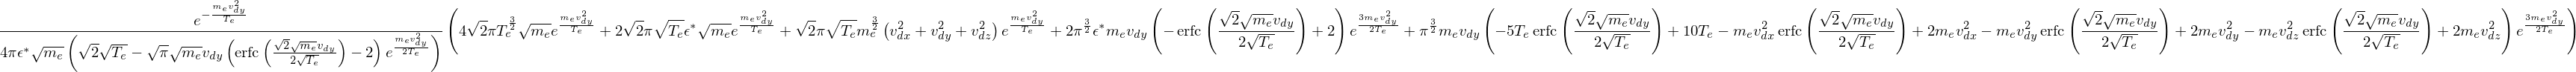

In [35]:
# SEE Rate
sigGamma_e = integ3(vy*sig_lin(v3.magnitude()**2*me/2)*Maxw3, 0, oo)

rate = sigGamma_e.simplify()/Gamma_e
rate = rate.simplify()
rate

In [34]:
# Substitution
def eval_val(eps, Te_v,vx_v,vy_v,vz_v):
    
    SubsDict = {me : me_v,
               epstar : eps,
               vdy: vy_v,
               vdx: vx_v,
               vdz: vz_v,
               Te: Te_v
               }

    s = rate.subs(SubsDict).evalf().simplify()

    return s



In [42]:
# Evaluate values

print(Te_w)
print(Ve_x*1e-6)
print(Ve_y*1e-6)
print(Ve_z*1e-6)

#Ve_x, Ve_y, Ve_z = Ve_x[mask], Ve_y[mask], Ve_z[mask]

#sigm_theo = np.array([eval_val(*args) for args in zip(eps_v, Te_w, Ve_x, Ve_y, Ve_z,)])

sigma_pic_lin = np.array([sig_lin(2*t).subs({epstar: e}).evalf() for t,e in zip(Te_w, eps_v)])

print(eps_v)
sigma_pic_lin

[11.21362797  4.93713922  3.67603179  6.40504603]
[-0.59226227 -0.18757821 -1.00862928 -0.73077377]
[-0.11153141  0.02806326 -0.84777541 -0.32723849]
[-0.09976853 -0.17054007 -0.05507064  0.00116052]
[ 50  10 400 200]


array([0.724272559463891, 0.993713922414099, 0.509190079474029,
       0.532025230125938], dtype=object)

In [ ]:
sigma_pic_lin

In [ ]:
plt.scatter(eps_v,sigm_theo, label = "drifting Maxwellian")
plt.scatter(eps_v, sigma_pic_lin , label = "non-drifting Maxw")
plt.legend()